# Read in Required Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import decomposition
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Read in dataset and do some exploratory analysis

In [2]:
df = pd.read_csv('training_data.csv')
df.head()

,Unnamed: 0,ID,gender,Management,USAcitizen,Married,MonthsInUnion,ContinuingEd,FeatureA,Connectivity,...,FeatureE,FeatureF,FeatureG,FeatureB,DuesFrequency,PaperlessBilling,PaymentMethod,MonthlyDues,TotalDues,LeftUnion
0,936,Daniel1,Female,0,No,No,12,No,Maryville,DSL,...,No,Yes,No,No,One year,Yes,Mailed check,34,435,No
1,4102,Daniel2,Male,0,Yes,No,50,Yes,No,Dial-in,...,Maryville,Maryville,Maryville,Maryville,Two year,No,Electronic check,20,1013,No
2,3888,Daniel3,Female,1,Yes,No,72,Yes,Yes,Fiber optic,...,No,No,Yes,Yes,One year,Yes,Bank transfer (automatic),107,7677,No
3,3864,Daniel4,Male,0,Yes,Yes,70,Yes,Yes,Dial-in,...,Maryville,Maryville,Maryville,Maryville,Two year,No,Mailed check,25,1782,No
4,4371,Daniel5,Male,0,No,No,3,No,Maryville,DSL,...,No,No,No,No,Month-to-month,No,Electronic check,25,67,Yes


In [3]:
# Check for NaN values
print(df.isna().sum())

Unnamed: 0          0
ID                  0
gender              0
Management          0
USAcitizen          0
Married             0
MonthsInUnion       0
ContinuingEd        0
FeatureA            0
Connectivity        0
FeatureC            0
FeatureD            0
FeatureE            0
FeatureF            0
FeatureG            0
FeatureB            0
DuesFrequency       0
PaperlessBilling    0
PaymentMethod       0
MonthlyDues         0
TotalDues           0
LeftUnion           0
dtype: int64


In [4]:
#Going to check for outliers. Start with seeing which columns need to be checked (numeric collumns)

print(df.dtypes)

Unnamed: 0           int64
ID                  object
gender              object
Management           int64
USAcitizen          object
Married             object
MonthsInUnion        int64
ContinuingEd        object
FeatureA            object
Connectivity        object
FeatureC            object
FeatureD            object
FeatureE            object
FeatureF            object
FeatureG            object
FeatureB            object
DuesFrequency       object
PaperlessBilling    object
PaymentMethod       object
MonthlyDues          int64
TotalDues           object
LeftUnion           object
dtype: object


Text(0.5, 1.0, 'Months in Union Box Plot')

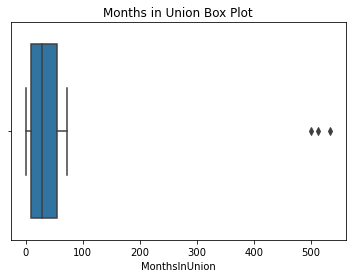

In [5]:
#outlier check list
sns.boxplot(data=df, x='MonthsInUnion',hue='LeftUnion')
plt.title('Months in Union Box Plot')

Text(0.5, 1.0, 'Monthly Dues Box Plot')

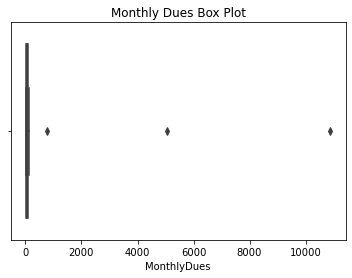

In [6]:
sns.boxplot(data=df, x='MonthlyDues',hue='LeftUnion')
plt.title('Monthly Dues Box Plot')

# Visualize the data further

## Scatter Plot

<AxesSubplot:xlabel='MonthlyDues', ylabel='MonthsInUnion'>

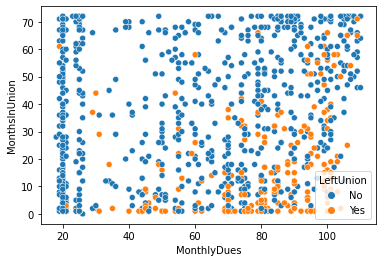

In [7]:
df_filtered = df[df['MonthlyDues']<=110]
sns.scatterplot(data=df_filtered, x='MonthlyDues', y='MonthsInUnion', hue='LeftUnion')

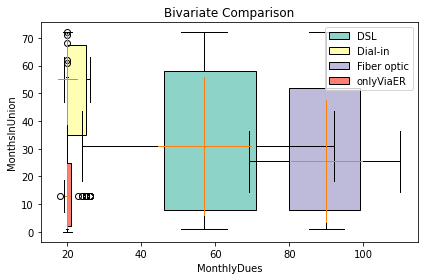

In [8]:
categories = df['Connectivity'].unique()
colors = plt.cm.Set3.colors
x_column, y_column = 'MonthlyDues', 'MonthsInUnion'
for cat, color in zip(categories, colors):
    # x-axis: Monthly dues
    x_data = df_filtered[df_filtered['Connectivity'] == cat][x_column]
    x_q1, x_median, x_q3 = np.percentile(x_data, [25, 50, 75])
    # y-axis: Months in the Union
    y_data = df_filtered[df_filtered['Connectivity'] == cat][y_column]
    y_q1, y_median, y_q3 = np.percentile(y_data, [25, 50, 75])
    plt.boxplot(x_data, positions=[y_median], widths=y_q3 - y_q1, vert=False,
                showbox=False, manage_ticks=False)
    plt.boxplot(y_data, positions=[x_median], widths=x_q3 - x_q1,
                showbox=False, manage_ticks=False,
                boxprops={'facecolor': color, 'label': cat})
    plt.gca().add_patch(plt.Rectangle((x_q1, y_q1), x_q3 - x_q1, y_q3 - y_q1,
                                      facecolor=color, edgecolor='black', label=cat))
plt.title('Bivariate Comparison')
plt.xlabel(x_column)
plt.ylabel(y_column)
plt.legend()
plt.tight_layout()
plt.show()

# Evidence of outliers. Need to Standardize the data

In [9]:
#split dataset into numeric and categorical features

#first need to investigate why the TotalDues column is of object type
print(df['TotalDues'].unique())

['435' '1013' '7677' '1782' '67' '1399' '615' '1039' '4563' '3012' '20'
 '889' '2165' '54' '789' '330' '416' '1391' '5309' '1428' '470' '372'
 '914' '2152' '2215' '1110' '197' '1052' '4234' '1709' '2586' '5073'
 '1071' '1517' '42' '2110' '4534' '2387' '5154' '932' '2511' '6293' '1359'
 '2949' '100' '1030' '730' '3196' '4903' '964' '1346' '5614' '627' '679'
 '46' '44' '2439' '1360' '7209' '36' '2362' '1718' '260' '1862' '810'
 '2680' '5657' '1375' '5931' '1012' '1929' '883' '5295' '5018' '511'
 '3688' '1733' '1620' '2201' '3770' '4126' '6298' '2647' '294' '6369'
 '521' '2245' '89' '1510' '261' '1025' '3480' '3619' '76' '1303' '357'
 '2472' '1611' '279' '610' '6999' '3759' '6307' '252' '5468' '158' '762'
 '256' '1017' '534' '1582' '1752' '147' '2659' '5424' '2634' '1759' '912'
 '5301' '1431' '494' '1091' '2920' '825' '1194' '144' '162' '1378' '234'
 '2384' '7854' '223' '720' '555' '6496' '4972' '2893' '625' '6813' '340'
 '655' '2249' '154' '335' '6076' '149' '1318' '185' '8306' '4177' '1

In [10]:
#Need to replace the '#VALUE with numeric value'
df['TotalDues'] = np.where(df['TotalDues']=='#VALUE!', 0, df['TotalDues'])
#check
print(np.sum(df['TotalDues']=='#VALUE!'))

0


In [11]:
#scale numerical columns
scaler = StandardScaler()
df[['MonthsInUnion', 'MonthlyDues', 'TotalDues']] = scaler.fit_transform(df[['MonthsInUnion', 'MonthlyDues', 'TotalDues']])
df

,Unnamed: 0,ID,gender,Management,USAcitizen,Married,MonthsInUnion,ContinuingEd,FeatureA,Connectivity,...,FeatureE,FeatureF,FeatureG,FeatureB,DuesFrequency,PaperlessBilling,PaymentMethod,MonthlyDues,TotalDues,LeftUnion
0,936,Daniel1,Female,0,No,No,-0.598502,No,Maryville,DSL,...,No,Yes,No,No,One year,Yes,Mailed check,-0.123991,-0.808685,No
1,4102,Daniel2,Male,0,Yes,No,0.451890,Yes,No,Dial-in,...,Maryville,Maryville,Maryville,Maryville,Two year,No,Electronic check,-0.161044,-0.548602,No
2,3888,Daniel3,Female,1,Yes,No,1.060011,Yes,Yes,Fiber optic,...,No,No,Yes,Yes,One year,Yes,Bank transfer (automatic),0.069212,2.450001,No
3,3864,Daniel4,Male,0,Yes,Yes,1.004728,Yes,Yes,Dial-in,...,Maryville,Maryville,Maryville,Maryville,Two year,No,Mailed check,-0.147811,-0.202574,No
4,4371,Daniel5,Male,0,No,No,-0.847279,No,Maryville,DSL,...,No,No,No,No,Month-to-month,No,Electronic check,-0.147811,-0.974274,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3145,Daniel996,Male,0,Yes,Yes,-0.570860,Yes,Yes,DSL,...,Yes,Yes,Yes,No,Month-to-month,Yes,Electronic check,-0.020773,-0.585949,No
996,3429,Daniel997,Female,0,Yes,No,-0.349725,Yes,Yes,Fiber optic,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,0.034806,-0.127879,No
997,4918,Daniel998,Female,0,No,No,-0.874921,Yes,Yes,Fiber optic,...,No,No,No,No,Month-to-month,No,Electronic check,-0.002247,-0.936026,No
998,3108,Daniel999,Female,0,No,No,0.451890,Yes,No,Dial-in,...,Maryville,Maryville,Maryville,Maryville,Two year,No,Credit card (automatic),-0.163690,-0.543652,No


In [12]:
#encode categorical columns
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df['USAcitizen'] = le.fit_transform(df['USAcitizen'])
df['Married'] = le.fit_transform(df['Married'])
df['ContinuingEd'] = le.fit_transform(df['ContinuingEd'])
df['FeatureA'] = le.fit_transform(df['FeatureA'])
df['Connectivity'] = le.fit_transform(df['Connectivity'])
df['FeatureC'] = le.fit_transform(df['FeatureC'])
df['FeatureD'] = le.fit_transform(df['FeatureD'])
df['FeatureE'] = le.fit_transform(df['FeatureE'])
df['FeatureF'] = le.fit_transform(df['FeatureF'])
df['FeatureG'] = le.fit_transform(df['FeatureG'])
df['FeatureB'] = le.fit_transform(df['FeatureB'])
df['DuesFrequency'] = le.fit_transform(df['DuesFrequency'])
df['PaperlessBilling'] = le.fit_transform(df['PaperlessBilling'])
df['PaymentMethod'] = le.fit_transform(df['PaymentMethod'])
df['LeftUnion'] = le.fit_transform(df['LeftUnion'])
df

,Unnamed: 0,ID,gender,Management,USAcitizen,Married,MonthsInUnion,ContinuingEd,FeatureA,Connectivity,...,FeatureE,FeatureF,FeatureG,FeatureB,DuesFrequency,PaperlessBilling,PaymentMethod,MonthlyDues,TotalDues,LeftUnion
0,936,Daniel1,0,0,0,0,-0.598502,0,0,0,...,1,2,1,1,1,1,3,-0.123991,-0.808685,0
1,4102,Daniel2,1,0,1,0,0.451890,1,1,1,...,0,0,0,0,2,0,2,-0.161044,-0.548602,0
2,3888,Daniel3,0,1,1,0,1.060011,1,2,2,...,1,1,2,2,1,1,0,0.069212,2.450001,0
3,3864,Daniel4,1,0,1,1,1.004728,1,2,1,...,0,0,0,0,2,0,3,-0.147811,-0.202574,0
4,4371,Daniel5,1,0,0,0,-0.847279,0,0,0,...,1,1,1,1,0,0,2,-0.147811,-0.974274,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3145,Daniel996,1,0,1,1,-0.570860,1,2,0,...,2,2,2,1,0,1,2,-0.020773,-0.585949,0
996,3429,Daniel997,0,0,1,0,-0.349725,1,2,2,...,1,1,2,2,0,1,2,0.034806,-0.127879,0
997,4918,Daniel998,0,0,0,0,-0.874921,1,2,2,...,1,1,1,1,0,0,2,-0.002247,-0.936026,0
998,3108,Daniel999,0,0,0,0,0.451890,1,1,1,...,0,0,0,0,2,0,1,-0.163690,-0.543652,0


In [13]:
#clean up the unnamed column and id column
df = df.rename(columns={'Unnamed: 0': 'alt_id'})
print(df['alt_id'].nunique())
print(df['ID'].nunique())

1000
1000


In [14]:
#no need to have both then. Drop ID since it contains a string
df = df.drop(columns=['ID'])
df

,alt_id,gender,Management,USAcitizen,Married,MonthsInUnion,ContinuingEd,FeatureA,Connectivity,FeatureC,...,FeatureE,FeatureF,FeatureG,FeatureB,DuesFrequency,PaperlessBilling,PaymentMethod,MonthlyDues,TotalDues,LeftUnion
0,936,0,0,0,0,-0.598502,0,0,0,2,...,1,2,1,1,1,1,3,-0.123991,-0.808685,0
1,4102,1,0,1,0,0.451890,1,1,1,0,...,0,0,0,0,2,0,2,-0.161044,-0.548602,0
2,3888,0,1,1,0,1.060011,1,2,2,2,...,1,1,2,2,1,1,0,0.069212,2.450001,0
3,3864,1,0,1,1,1.004728,1,2,1,0,...,0,0,0,0,2,0,3,-0.147811,-0.202574,0
4,4371,1,0,0,0,-0.847279,0,0,0,1,...,1,1,1,1,0,0,2,-0.147811,-0.974274,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,3145,1,0,1,1,-0.570860,1,2,0,1,...,2,2,2,1,0,1,2,-0.020773,-0.585949,0
996,3429,0,0,1,0,-0.349725,1,2,2,1,...,1,1,2,2,0,1,2,0.034806,-0.127879,0
997,4918,0,0,0,0,-0.874921,1,2,2,1,...,1,1,1,1,0,0,2,-0.002247,-0.936026,0
998,3108,0,0,0,0,0.451890,1,1,1,0,...,0,0,0,0,2,0,1,-0.163690,-0.543652,0


# PCA


In [15]:
X = df.drop(columns=['LeftUnion'])
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)
components = pca.components_

## Scree Plot

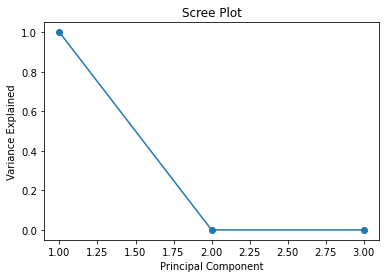

In [16]:
PC_values = np.arange(pca.n_components_) + 1
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

# Models

### Decision Tree Classifier

In [17]:
#split data into train and test
X = df.drop(columns=['LeftUnion'])
y = df['LeftUnion']

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.3)

In [18]:
#train tree
dt_train_acc = []
depth_range = range(2,30)

for i in depth_range:
    np.random.seed(1)
    temp_tree = DecisionTreeClassifier(max_depth=i)
    temp_tree.fit(X_train, y_train)
    dt_train_acc.append(temp_tree.score(X_train, y_train))
    
dt_idx = np.argmax(dt_train_acc)
dt_opt_depth = depth_range[dt_idx]
print(f'Optimal value for max_depth: {dt_opt_depth}')
print(f'Training Accuracy for Optimal Model: {np.round(dt_train_acc[dt_idx], 4)}')

Optimal value for max_depth: 16
Training Accuracy for Optimal Model: 1.0


In [19]:
#Might be overfitting the model. Feed test data to see how it performs
tree = DecisionTreeClassifier(max_depth=15)
tree.fit(X_train, y_train)
print(np.round(tree.score(X_test,y_test),4))
predictions = tree.predict(X_test)
cm = confusion_matrix(y_test, predictions)

cm_df = pd.DataFrame(cm, columns=['1','2'])
print(cm_df)

cr = classification_report(y_test, predictions)
print(cr)

0.7367
     1   2
0  186  32
1   47  35
              precision    recall  f1-score   support

           0       0.80      0.85      0.82       218
           1       0.52      0.43      0.47        82

    accuracy                           0.74       300
   macro avg       0.66      0.64      0.65       300
weighted avg       0.72      0.74      0.73       300



### Random Forrest Classifier

In [20]:
df_train_acc = []

for i in depth_range:
    np.random.seed(1)
    temp_forrest = RandomForestClassifier(max_depth=i, n_estimators=100)
    temp_forrest.fit(X_train, y_train)
    df_train_acc.append(temp_forrest.score(X_train, y_train))
rf_idx = np.argmax(df_train_acc)
rf_opt_depth = depth_range[rf_idx]

print(f'Optimal value for max depth: {rf_opt_depth}')
print(f'Training Accuracy for Optimal Model: {np.round(df_train_acc[rf_idx], 4)}')

Optimal value for max depth: 12
Training Accuracy for Optimal Model: 1.0


In [21]:
np.random.seed(1)

forest = RandomForestClassifier(max_depth=13, n_estimators=100)
forest.fit(X_train, y_train)

print(f'Training Accuracy for Random Forest: {np.round(forest.score(X_train, y_train), 4)}')

predictions = forest.predict(X_test)
cm = confusion_matrix(y_test, predictions)

cm_df = pd.DataFrame(cm, columns=['1','2'])
print(cm_df)

cr = classification_report(y_test, predictions)
print(cr)

Training Accuracy for Random Forest: 1.0
     1   2
0  203  15
1   52  30
              precision    recall  f1-score   support

           0       0.80      0.93      0.86       218
           1       0.67      0.37      0.47        82

    accuracy                           0.78       300
   macro avg       0.73      0.65      0.67       300
weighted avg       0.76      0.78      0.75       300



### Neural Network

In [22]:
clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,2), random_state=1)
X = df.drop(columns=['LeftUnion'])
y = df['LeftUnion']
clf.fit(X,y)
clf.score(X_train, y_train)

0.7614285714285715

In [23]:
clf.score(X_test, y_test)

0.7266666666666667

In [24]:
predictions = clf.predict(X_test)

cm = confusion_matrix(y_test, predictions)

cm_df = pd.DataFrame(cm, columns=['1','2'])
print(cm_df)

cr = classification_report(y_test, predictions)
print(cr)

     1  2
0  218  0
1   82  0
              precision    recall  f1-score   support

           0       0.73      1.00      0.84       218
           1       0.00      0.00      0.00        82

    accuracy                           0.73       300
   macro avg       0.36      0.50      0.42       300
weighted avg       0.53      0.73      0.61       300



C:\Anaconda\envs\PythonAdv\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
